- Set up [anaconda with python 3.7](https://www.anaconda.com/distribution/#download-section). **If you already have it installed** but you don't want to change the versions of your modules etc, you can make a new conda environment, with: ``conda create --name py37 python=3.7`` then activate it with ``source activate py37``.
    
- Next install [GPFlow](https://github.com/GPflow/GPflow). To do this we install from their development branch which can deal with the new Tensorflow:

        pip install git+https://github.com/GPflow/GPflow.git@develop#egg=gpflow
        
- "This will automatically install all required dependencies. (Note: as of January 2020, PyPI only has tensorflow 2.x for python 3.6 and 3.7, not for python 3.8, which is the latest release and the Anaconda default.)"
- I found that because I had an older version of tensorflow this broke, and I had to install the new version of tensorflow. And also run pip install --upgrade multipledispatch

Then based on the [notebook](https://github.com/GPflow/docs/blob/master/doc/source/notebooks/basics/regression.ipynb) provided by James.

In [37]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary
%matplotlib inline

In [34]:
X = 4+4*np.random.rand(20)[:,None]
Y = 1+np.cos(X)+0.1*np.random.randn(X.shape[0])[:,None]
k = gpflow.kernels.Matern52()
Y = Y - np.mean(Y)
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)

##We can set the parameters manually
#m.likelihood.variance.assign(0.01)
#m.kernel.lengthscales.assign(0.3)

##Or use maximum likelihood optimisation
#opt = gpflow.optimizers.Scipy()
#def objective_closure():
#    return - m.log_marginal_likelihood()
#
#opt_logs = opt.minimize(objective_closure,
#                        m.trainable_variables,
#                        options=dict(maxiter=100))

In [38]:
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

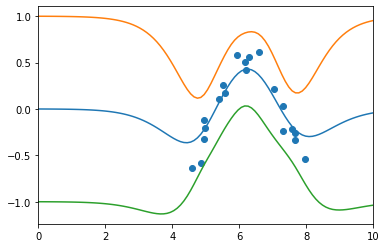

In [35]:
testX = np.linspace(0,10,100)[:,None]
testmeans, testvars = m.predict_f(testX)
plt.scatter(X,Y)
plt.xlim([0,10])
#plt.ylim([0,2])
plt.plot(testX,testmeans)
plt.plot(testX,testmeans+np.sqrt(testvars))
plt.plot(testX,testmeans-np.sqrt(testvars))

# Get Sensor Data

We need to install google-cloud-bigquery:

        pip install google-cloud-bigquery
        
Then using Dennis' code:

In [40]:
import pandas as pd
from google.cloud import bigquery
import numpy as np

In [47]:
client = bigquery.Client.from_service_account_json("/home/mike/.gcp_keys/AirQo-519978d8cadc.json")

In [69]:
def get_static_channels():
    sql = """
        SELECT channel_id 
        FROM `airqo-250220.thingspeak.channel` 
        WHERE NOT LOWER(name) LIKE '%mobile%' 
        LIMIT 1000
    """
    channels = [channel.channel_id for channel in client.query(sql).result()]
    return channels

channels = get_static_channels()
channels[0:5]



def get_df(channel_id):
    sql = """
    SELECT * FROM `airqo-250220.thingspeak.clean_feeds_pms` WHERE channel_id={}
    """.format(channel_id)

    df = client.query(sql).to_dataframe()
    return df

def get_loc(channel_id):
    sql = """
    SELECT channel_id, longitude, latitude 
    FROM `airqo-250220.thingspeak.channel`
    WHERE channel_id={}
    """.format(channel_id)

    df = client.query(sql).to_dataframe()
    
    return df


In [74]:
def get_entries_since(channel_id,daysago=7):
    from datetime import datetime,timedelta
    datestring = (datetime.now()-timedelta(daysago)).strftime("%Y-%m-%d %H:%M:%S") # current date and time

    sql = """
    SELECT created_at, channel_id, pm2_5 
    FROM `airqo-250220.thingspeak.clean_feeds_pms` 
    WHERE channel_id={} 
    AND created_at > '{}'
    """.format(channel_id,datestring)

    df = client.query(sql).to_dataframe() 
    
    return df

for chan in channels:
    d = get_entries_since(chan)
    loc = get_loc(chan)
    break

In [75]:
loc

,channel_id,longitude,latitude
0,930426,32.6468,0.3655


6016

In [88]:
d

,created_at,channel_id,pm2_5
0,2020-03-22 13:37:00,930426,16.13
1,2020-03-22 12:16:29,930426,55.18
2,2020-03-22 07:01:31,930426,15.18
3,2020-03-22 14:04:28,930426,30.00
4,2020-03-22 07:45:50,930426,21.97
...,...,...,...
6011,2020-03-17 23:45:52,930426,6.02
6012,2020-03-18 00:00:15,930426,17.43
6013,2020-03-17 23:30:40,930426,9.32
6014,2020-03-17 23:38:50,930426,4.55


In [113]:
X = np.c_[np.repeat(np.array(loc)[:,1:],d.shape[0],0),[n.timestamp()/3600 for n in d['created_at']]]
X[:,-1]-=np.min(X[:,-1])

In [118]:
Y = np.array(d['pm2_5'])[:,None]

In [119]:
X

array([[ 32.6468    ,   0.3655    , 110.28805556],
       [ 32.6468    ,   0.3655    , 108.94611111],
       [ 32.6468    ,   0.3655    , 103.69666667],
       ...,
       [ 32.6468    ,   0.3655    ,   0.1825    ],
       [ 32.6468    ,   0.3655    ,   0.31861111],
       [ 32.6468    ,   0.3655    ,   0.205     ]])

In [120]:
Y

array([[16.13],
       [55.18],
       [15.18],
       ...,
       [ 9.32],
       [ 4.55],
       [ 9.12]])

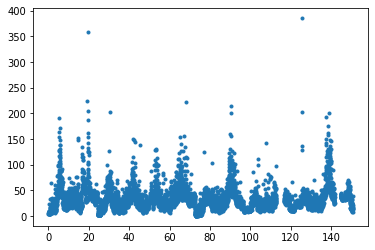

In [123]:
plt.plot(X[:,-1],Y,'.')